In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import pathlib

2022-05-22 06:00:41.828862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-22 06:00:41.828886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
url1 = 'https://storage.googleapis.com/download.tensorflow.org/'
url2 = 'example_images/flower_photos.tgz'
dataset_url = url1 + url2
data_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    fname='flower_photos',
    untar=True)
data_dir = pathlib.Path(data_dir)

data_dir

PosixPath('/home/calcifer/.keras/datasets/flower_photos')

In [3]:
!ls -l ~/.keras/datasets/flower_photos

total 620
drwx------ 2 calcifer calcifer  36864 Feb 10  2016 daisy
drwx------ 2 calcifer calcifer  53248 Feb 10  2016 dandelion
-rw-r----- 1 calcifer calcifer 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 calcifer calcifer  36864 Feb 10  2016 roses
drwx------ 2 calcifer calcifer  45056 Feb 10  2016 sunflowers
drwx------ 2 calcifer calcifer  40960 Feb 10  2016 tulips


In [4]:
roses = list(data_dir.glob("roses/*"))
roses[:3]

[PosixPath('/home/calcifer/.keras/datasets/flower_photos/roses/2535466393_6556afeb2f_m.jpg'),
 PosixPath('/home/calcifer/.keras/datasets/flower_photos/roses/5073473370_bdbb5a99fc.jpg'),
 PosixPath('/home/calcifer/.keras/datasets/flower_photos/roses/2675221506_5286c0595f.jpg')]

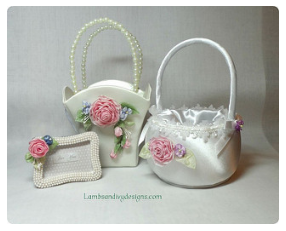

In [5]:
img_idx = np.random.randint(len(roses))
img = np.array(Image.open(str(roses[img_idx])))
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
BATCH_SIZE = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(data_dir),
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=(img_width, img_height),
    seed=0,
    validation_split=.8,
    subset="training",
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(data_dir),
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=(img_width, img_height),
    seed=0,
    validation_split=.8,
    subset="validation",
)

Found 3670 files belonging to 5 classes.
Using 734 files for training.
Found 3670 files belonging to 5 classes.
Using 2936 files for validation.


2022-05-22 06:00:43.527549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-22 06:00:43.527569: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-22 06:00:43.527583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2022-05-22 06:00:43.527856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
for img, lbl in train_ds.take(1):
    batch_size = img.shape[0]
    img_shape = img.shape[1:3]
    input_shape = img.shape[1:]
batch_size, img_shape, input_shape

(32, TensorShape([180, 180]), TensorShape([180, 180, 3]))

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
def format_image(image, label):
    image = tf.image.resize(image, img_shape) / 255.0
    return image, label

In [12]:
SHUFFLE_SIZE = 5000

In [13]:
train_ds_fmt = (
    train_ds
    .map(format_image)
    .shuffle(SHUFFLE_SIZE)
    .cache()
    .prefetch(1)
)
test_ds_fmt = (
    test_ds
    .map(format_image)
    .cache()
    .prefetch(1)
)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D

In [15]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

In [16]:
MaxPooling2D?

Init signature: MaxPooling2D(*args, **kwargs)
Docstring:     
Max pooling operation for 2D spatial data.

Downsamples the input along its spatial dimensions (height and width)
by taking the maximum value over an input window
(of size defined by `pool_size`) for each channel of the input.
The window is shifted by `strides` along each dimension.

The resulting output,
when using the `"valid"` padding option, has a spatial shape
(number of rows or columns) of:
`output_shape = math.floor((input_shape - pool_size) / strides) + 1`
(when `input_shape >= pool_size`)

The resulting output shape when using the `"same"` padding option is:
`output_shape = math.floor((input_shape - 1) / strides) + 1`

For example, for `strides=(1, 1)` and `padding="valid"`:

>>> x = tf.constant([[1., 2., 3.],
...                  [4., 5., 6.],
...                  [7., 8., 9.]])
>>> x = tf.reshape(x, [1, 3, 3, 1])
>>> max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
...    strides=(1, 1), padding='valid

In [19]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    Dropout(0.2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    Dropout(0.2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 43, 43, 32)       

In [20]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [21]:
EPOCHS = 5

history = model.fit(
    train_ds_fmt,
    verbose=1,
    epochs=EPOCHS,
    validation_data=test_ds_fmt,
)

Epoch 1/5
23/23 [==============================] - 21s 896ms/step - loss: 1.6690 - accuracy: 0.2275 - val_loss: 1.5771 - val_accuracy: 0.2554
Epoch 2/5
23/23 [==============================] - 22s 954ms/step - loss: 1.3810 - accuracy: 0.4128 - val_loss: 1.2430 - val_accuracy: 0.4394
Epoch 3/5
23/23 [==============================] - 24s 1s/step - loss: 1.1676 - accuracy: 0.4946 - val_loss: 1.2267 - val_accuracy: 0.4768
Epoch 4/5
23/23 [==============================] - 21s 947ms/step - loss: 1.0258 - accuracy: 0.5763 - val_loss: 1.1986 - val_accuracy: 0.4901
Epoch 5/5
23/23 [==============================] - 22s 960ms/step - loss: 0.9356 - accuracy: 0.6294 - val_loss: 1.1515 - val_accuracy: 0.5143
